In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from pathlib import Path

In [2]:
DATA_PATH = Path("../data/clean_panel.csv")   # cleaned panel from Notebook 01
OUTDIR    = Path("../output/event_study_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

In [3]:
WINDOW_MONTHS = 6          
MIN_OBS_FOR_EST = 30       
THRESH_MULTIPLIER = 1.5     
TOP_N_SHOCKS = None

In [4]:
panel = pd.read_csv(DATA_PATH, parse_dates=['Date'])
panel = panel.sort_values(['State', 'Date']).reset_index(drop=True)

weights = pd.read_excel("../data/weight.xlsx", sheet_name="s1", index_col=0)
states = panel['State'].unique()
weights = weights.reindex(index=states, columns=states).fillna(0)
weights = weights.div(weights.sum(axis=1), axis=0).fillna(0)

panel.head()

,State,Year,Month,relc,Month_num,Date
0,Andhra Pradesh,2011,January,0.012216,1,2011-01-01
1,Andhra Pradesh,2011,February,0.000000,2,2011-02-01
2,Andhra Pradesh,2011,March,-0.003399,3,2011-03-01
3,Andhra Pradesh,2011,April,-0.007887,4,2011-04-01
4,Andhra Pradesh,2011,May,-0.004464,5,2011-05-01


In [5]:
sigma_series = panel.groupby('Date')['relc'].std().reset_index(name='sigma').dropna()

def weighted_sigma(df, w):
    svals = df.set_index('State')['relc']
    wvec = w.loc[svals.index].mean(axis=1)  
    wvec = wvec / wvec.sum()
    mu = np.sum(wvec * svals)
    return np.sqrt(np.sum(wvec * (svals - mu)**2))

weighted_sigmas = []
for d, g in panel.groupby('Date'):
    weighted_sigmas.append({'Date': d, 'w_sigma': weighted_sigma(g, weights)})
weighted_sigma_series = pd.DataFrame(weighted_sigmas)

if TOP_N_SHOCKS is not None:
    chosen = sigma_series.sort_values('sigma', ascending=False).head(TOP_N_SHOCKS)
    shock_dates = pd.to_datetime(chosen['Date']).sort_values().tolist()
    method_desc = f"Top {TOP_N_SHOCKS} sigma months"
else:
    thresh = THRESH_MULTIPLIER * sigma_series['sigma'].mean()
    shock_dates = sigma_series.loc[sigma_series['sigma'] > thresh, 'Date'].tolist()
    method_desc = f"Sigma > {THRESH_MULTIPLIER} × mean sigma"



In [6]:
shock_rows = []
sigma_all  = []
w_sigma_all = []  

for sdate in shock_dates:
    start = sdate - pd.DateOffset(months=WINDOW_MONTHS)
    end   = sdate + pd.DateOffset(months=WINDOW_MONTHS)
    win = panel[(panel['Date'] >= start) & (panel['Date'] <= end)].copy()
    if win.empty:
        continue

    win['event_time'] = win['Date'].apply(
        lambda d: (d.year - sdate.year) * 12 + (d.month - sdate.month)
    )
    sigma_path = win.groupby('event_time')['relc'].std().reset_index()
    sigma_path['shock_date'] = sdate.date()
    sigma_all.append(sigma_path)

    def weighted_sigma(df):
        svals = df.set_index('State')['relc']
        wvec = weights.loc[svals.index].mean(axis=1)   # simple mean of row weights
        wvec = wvec / wvec.sum()
        mu = np.sum(wvec * svals)
        return np.sqrt(np.sum(wvec * (svals - mu) ** 2))

    w_sigma_path = (
        win.drop(columns=['event_time'])
           .groupby(win['event_time'])
           .apply(weighted_sigma)
           .reset_index(name='w_sigma')
    )
    w_sigma_path['shock_date'] = sdate.date()
    w_sigma_all.append(w_sigma_path)

    win['lag_rel'] = win.groupby('State')['relc'].shift(1)
    win['d_rel']   = win.groupby('State')['relc'].diff()
    regdata = win.dropna(subset=['lag_rel','d_rel']).copy()
    n_obs = len(regdata)

    if n_obs < MIN_OBS_FOR_EST:
        shock_rows.append({
            'shock_date': sdate.date(), 'n_obs': n_obs,
            'beta': np.nan, 'se': np.nan, 'half_life_months': np.nan
        })
        continue

    X = add_constant(regdata['lag_rel'])
    y = regdata['d_rel']
    model = sm.OLS(y, X).fit(cov_type='HC1')
    beta = model.params.get('lag_rel', np.nan)
    se   = model.bse.get('lag_rel', np.nan)

    hl = np.nan
    if (beta is not None) and (-1 < beta < 0):
        try:
            hl = np.log(0.5) / np.log(1 + beta)
        except:
            hl = np.nan

    shock_rows.append({
        'shock_date': sdate.date(), 'n_obs': n_obs,
        'beta': float(beta), 'se': float(se),
        'half_life_months': float(hl) if not np.isnan(hl) else np.nan
    })

shock_df = pd.DataFrame(shock_rows).sort_values('shock_date').reset_index(drop=True)

sigma_df = pd.concat(sigma_all, ignore_index=True)
sigma_df.rename(columns={'relc': 'avg_sigma'}, inplace=True)
w_sigma_df = pd.concat(w_sigma_all, ignore_index=True)
sigma_df = sigma_df.merge(w_sigma_df, on=['event_time','shock_date'], how='left')
shock_df.to_csv(OUTDIR / "shock_beta_summary.csv", index=False)
sigma_df.to_csv(OUTDIR / "sigma_convergence_event_path.csv", index=False)

print("Saved CSVs to:", OUTDIR)
display(shock_df.head())
display(sigma_df.head())


Saved CSVs to: ..\output\event_study_outputs


,shock_date,n_obs,beta,se,half_life_months
0,2024-05-01,396,0.002907,0.007999,NaN
1,2024-06-01,396,0.001047,0.007953,NaN
2,2024-11-01,264,-0.008953,0.011830,77.071265
3,2024-12-01,231,-0.008881,0.012567,77.700447
4,2025-01-01,198,0.005372,0.013360,NaN


,event_time,avg_sigma,shock_date,w_sigma
0,-6,0.044594,2024-05-01,0.043914
1,-5,0.046106,2024-05-01,0.045402
2,-4,0.045833,2024-05-01,0.045133
3,-3,0.045795,2024-05-01,0.045096
4,-2,0.045684,2024-05-01,0.044987


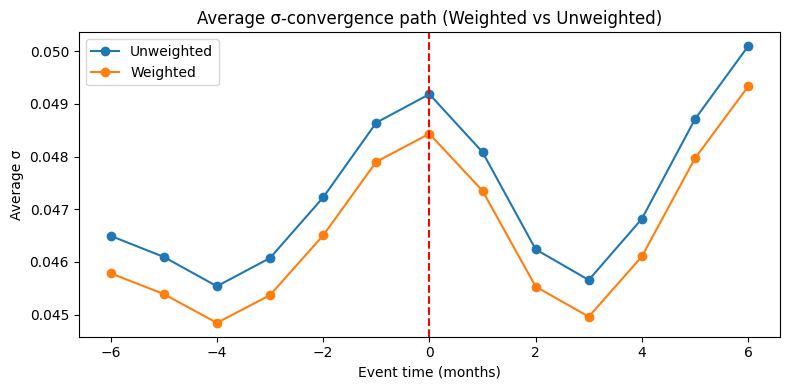

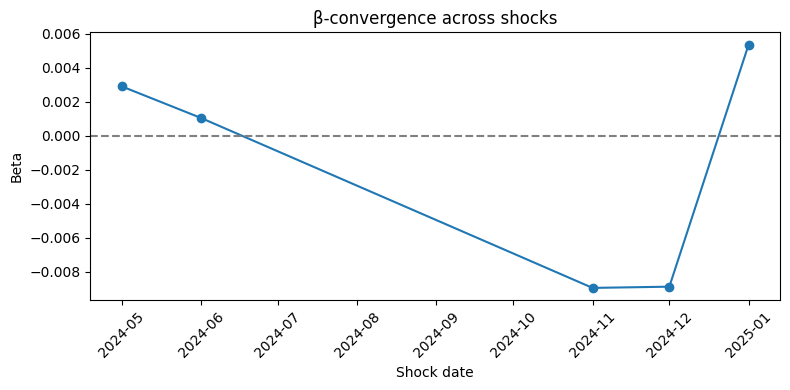

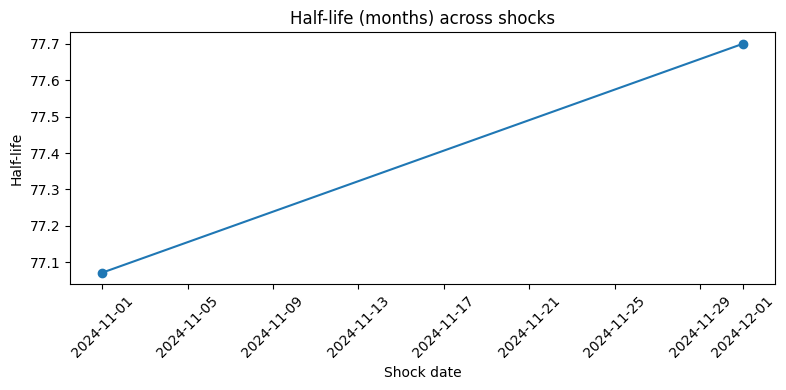

In [7]:
# σ-path across shocks (unweighted vs weighted)
avg_sigma = sigma_df.groupby('event_time')['avg_sigma'].mean().reset_index()
avg_w_sigma = sigma_df.groupby('event_time')['w_sigma'].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(avg_sigma['event_time'], avg_sigma['avg_sigma'],
         marker='o', label="Unweighted")
plt.plot(avg_w_sigma['event_time'], avg_w_sigma['w_sigma'],
         marker='o', label="Weighted")
plt.axvline(0, color='red', linestyle='--')
plt.title("Average σ-convergence path (Weighted vs Unweighted)")
plt.xlabel("Event time (months)")
plt.ylabel("Average σ")
plt.legend()
plt.tight_layout()
plt.show()


# β-path across shocks
plt.figure(figsize=(8,4))
plt.plot(shock_df['shock_date'], shock_df['beta'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title("β-convergence across shocks")
plt.xlabel("Shock date")
plt.ylabel("Beta")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Half-life
plt.figure(figsize=(8,4))
plt.plot(shock_df['shock_date'], shock_df['half_life_months'], marker='o')
plt.title("Half-life (months) across shocks")
plt.xlabel("Shock date")
plt.ylabel("Half-life")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
